In [ ]:
from pathlib import Path
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords
#nltk.download('stopwords')
stoplist = stopwords.words('english')

# MPL block
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (10,5)
import os
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA


## The LetterBoxd Corpus

Letterboxd is a social media where users log and review movies. It happens to be one of the social medias that I use more heavily, so I was interested in making a corpus out of user reviews in order to see what data can be acquired from anonymous movie opinions.

I was lucky enough to find an existing github repository made 4 years ago that seemed to scrape letterboxd on a linux machine. It already had functionality to find every valid URL page of reviews for a given user and write lines of text to .json; I just needed to change the html parsing to work for me.

Here are excerpts of my code from movies.py , where the letterboxd scraping is done. I've commented it all out because it's just meant to be viewed, not ran here.


In [ ]:
#there's code up here that i did not write
#it takes arguments for specific user/whether to write json
#it grabs the valuable parts of html 
#it can be viewed fully in the movies.py file
"""
#grab titles from html

        titles = []
        reviews = []
        for line in smallStr.splitlines():
            soup = BeautifulSoup(line, 'html.parser')
            div_tags = soup.find_all('div')
            for div_tag in div_tags:
                title = div_tag.get('data-film-slug')
                if title is not None:
                    titles.append(title)

#this function gets rid of weird unicode stuff and extra garbage

def clean(string):
    string = string.replace('\n', ' ').replace('\\', ' ').replace('’', '\'')
    string = string.replace('“', '\"').replace('”', '\"').replace("…", "...")
    string = string.replace('This review may contain spoilers. I can handle the truth.', ' ')
    return string
"""

In [ ]:
"""
#save the rating out of ten given by the user
#then discard more html

            ratingIndex = line.find('-green rated-')
            chopped0 = line[ratingIndex:]
            rating = ""
            if ratingIndex != -1:
                rating = chopped0[13:15] + "/10"
                rating = rating.replace("\"", "")
            reviewStart = line.find('-prose')
"""

In [ ]:
"""
#grab reviews    

            if reviewStart != -1:
                chopped = line[reviewStart:]
                soup = BeautifulSoup(chopped, 'html.parser')
                paragraphs = [p.get_text() for p in soup.find_all('p')]
                paragraphs = [s + " " for s in paragraphs]
                #rprint(paragraphs)
                reviewStr = "\n".join(paragraphs)
                reviewStr = rating + " " + reviewStr
                reviews.append(clean(reviewStr))
"""

In [ ]:
"""
#if a review contains a weird unicode elipses, we have to visit its individual URL to grab the full thing

        for i in range (len(titles)):
            #if review contains weird ...
            if "…" in reviews[i]:
                reviewsText[titles[i]] = getSingleReview(url=f'https://letterboxd.com/{user}/film/{titles[i]}/')
            #if review fits in the preview
            else:
                reviewsText[titles[i]] = reviews[i]
                
def getSingleReview(url=''):
    for possibleUrl in (url, url + '/1/'):  # super-8 review had a an extra /1/ on the end
        soup = BeautifulSoup(requests.get(possibleUrl).text, 'html.parser')
        reviewDivHtmlStr = str(soup.find("div", {'class': "review body-text -prose -hero -loose"}))
        sleep(.05)
        if not reviewDivHtmlStr == 'None':
            my_string = '<p>' + reviewDivHtmlStr.split('<div><p>')[-1].replace('</div>', '')
            my_string = re.sub(r'<(\/?p|br).*?>', ' ', my_string)
            return clean(my_string)
"""
#-----------------------------------------------------------------------------------------------------------------
#movies.py goes on to use more code that i did not write to create a .json file containing all the reviews scraped
#-----------------------------------------------------------------------------------------------------------------

So I started grabbing reviews from the most popular users on letterboxd, as well as myself, and storing the .jsons in the letterboxdCorpus folder. I stopped after 16 popular users, who altogether have written 25,000+ reviews. Time to convert all the files into a single .csv

In [ ]:
#this code turns it all into a .csv
"""
directory = "C:\\Users\Connor\Desktop\\370\letterboxdCorpus"

dfs = []
for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                userDf = pd.DataFrame.from_dict(data)
                dfs.append(userDf)
df = pd.concat(dfs, ignore_index=False)
print(df)
df.to_csv("C:/Users/Connor/Desktop/letterboxd/letterboxdCorpus/all.csv")
"""

here's a preview of the csv. it's very fun to look at and sort in google sheets

In [56]:
df = pd.read_csv('..\letterboxdCorpus\\all.csv')
df.head()

,movie,user,reviews
0,100-girls,24framesofnick,1/10 I highly recommend everyone get drunk wit...
1,12-rounds,24framesofnick,1/10 My introduction to John cena's absolutely...
2,2-fast-2-furious,24framesofnick,5/10 Not fast enough!
3,21-jump-street,24framesofnick,10/10 On march 24th 2023 Kanye West said he is...
4,80-for-brady,24framesofnick,4/10 Why are old people having fun they're lit...


In [57]:
df.shape

(25344, 3)

## Document Term Matrix

I'm not very good at drawing conclusions from DTM, and I probably still need to make a better stopword list.

In [58]:
reviews = df.reviews.tolist()
vectorizer = CountVectorizer(min_df=5, lowercase = True, stop_words = 'english')
X = vectorizer.fit_transform(reviews)
df2 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
#displaying the DTM may cause lag
#uncomment at your own risk
#df2.head()

Let me get rid of the scores for now

In [59]:
scoreless = []
for review in reviews:
    scoreless.append(review[5:])
print(scoreless[0:5])

['I highly recommend everyone get drunk with friends and watch this     ', "My introduction to John cena's absolutely delicious looking biceps     ", 'Not fast enough!     ', ' On march 24th 2023 Kanye West said he is no longer anti semitic because of this movie and Jonah Hill     ', "Why are old people having fun they're literally gonna die tomorrow 😭     "]


## Clustering
I am very much lost when it comes to k-means, but this is just me going through the motions.

In [60]:
vectorizer = TfidfVectorizer(lowercase = True,
                             min_df = 10,
                             stop_words='english')
matrix = vectorizer.fit_transform(scoreless)

vocabulary = vectorizer.get_feature_names_out()

matrix.shape

(25344, 7915)

In [ ]:
wcss = [] 
for i in range(1, 30): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(matrix) 
    wcss.append(kmeans.inertia_)

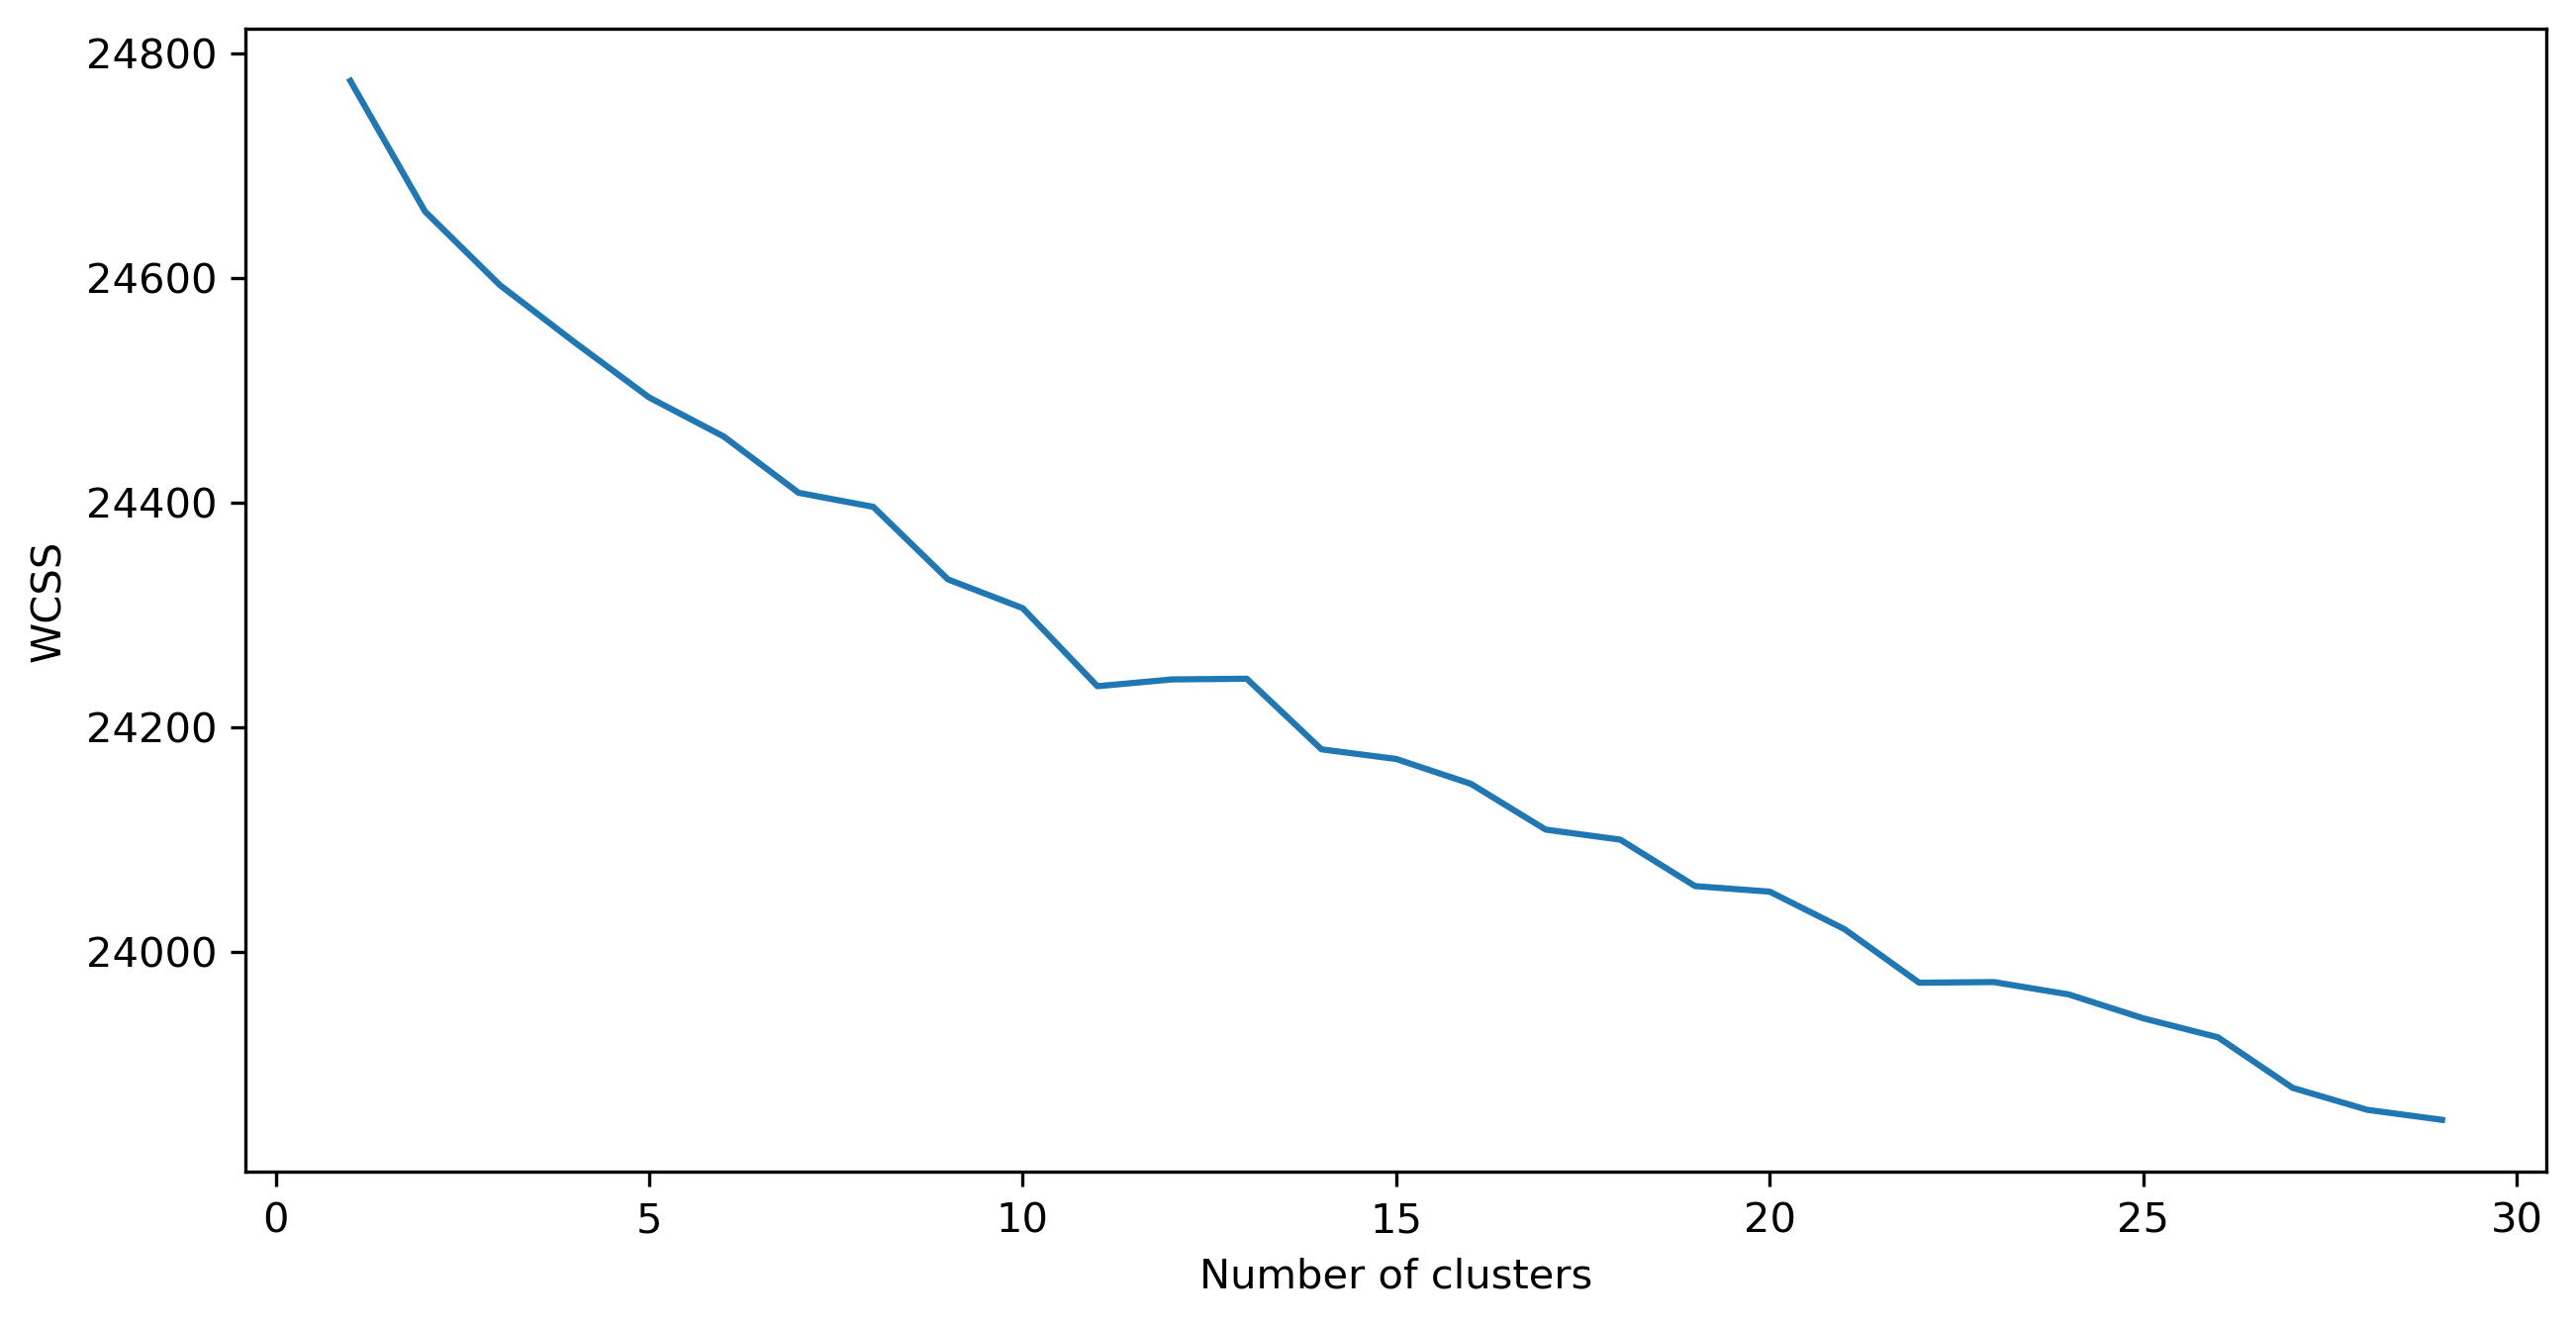

In [62]:
plt.plot(range(1, 30), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

That sure is a graph. I do wonder what it means.

In [ ]:

nmf = NMF(n_components=17, 
          random_state=1, 
          max_iter=500, 
          init='nndsvd').fit(matrix)
nmf_W = nmf.transform(matrix)
nmf_H = nmf.components_
nmf_W.shape

In [ ]:
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "{:d}: ".format(topic_idx)
        message += " ".join([feature_names[i] + ' ' + str(round(topic[i], 2)) + ','
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

NMF topics! A disappointing amount of people's words are used to plug their podcasts or patreons or whatever. But I do appreciate the frequency of swear words.

In [ ]:
display_topics(nmf, vocabulary, 10)

In [ ]:
cv = CountVectorizer(lowercase = True,
                     min_df = 10,
                     stop_words='english')

X = cv.fit_transform(scoreless)

lda_vocab = cv.get_feature_names_out()

X.shape

To be honest, most of these words are ones I'd expect from internet movie reviews.

In [ ]:
lda = LDA(n_components=17).fit(matrix)
display_topics(lda, lda_vocab, 10)

## Collocations Findings

First, make a big string of all the reviews.

In [ ]:
#big string
str = ""
reviews = df.reviews.tolist()
for review in reviews:
    str += review[5:] + " "
#this one takes a while

In [ ]:
def lemmify(a_string):
    """
    processed takes a string and returns a list of lemmas
    Requires the following imports:
    -------------------------------
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer() 
    """
    # Get rid of HTML (or HTML-like) tags
    clean = re.sub('<.*?>', '', a_string)
    # first we lower-case everything
    lowered = clean.lower()
    # then tokenize
    tokens = word_tokenize(lowered)
    # remove stopwords
    words = [token for token in tokens if token not in stoplist]
    # lemmatize
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    # Return a list of lemmas
    return lemmas

Again, more evidence of shamless podcast plugs. And then some common phrases. If you ctrl+f "podcast sleazoids" in the csv some guy mentions it over 400 times.

In [ ]:
tokens = lemmify(str)

corpus = nltk.Text(tokens)

corpus.collocations()


Here's an idea of what the average letterboxd review is. It may be chance, but this particular instance has a fair bit of negative/critical words. 

In [ ]:
corpus.generate()